In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchwi import Tomo2d
from Net import Tomography_CNN
from SSIM import SSIM
from torch.optim.lr_scheduler import MultiplicativeLR
import time
import copy

In [4]:
import sys
from pathlib import Path
from pkrh.torchwi import param_selector, get_land_mask

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0  Device: cuda


In [6]:
nx=320
ny=50
nshot=200
h=0.1
# marm
#h=0.0288 
shotskip=2

In [7]:
sxs = (104 + np.arange(nshot))*h
sy = 0.
ry = 0.

In [8]:
rx = np.zeros((nshot,2),dtype=np.int32)

for ishot in range(nshot):
    rx[ishot,0] = 2 + ishot
    rx[ishot,1] = rx[ishot,0] + 100
    
print("nshot=%d, sy=%s, ry=%s"%(nshot,sy,ry))

nshot=200, sy=0.0, ry=0.0


In [9]:
rcv_mask = np.zeros((nshot,nx),dtype=bool)

for ishot in range(nshot):
    ir0 = rx[ishot,0]
    ir1 = rx[ishot,1]
    rcv_mask[ishot,ir0:ir1] = True

In [10]:
rcv_mask = torch.from_numpy(rcv_mask).cuda()

In [11]:
tomo = Tomo2d(nx,ny,h,device='cuda')
freq = 0.05
vmean = 3.0

In [12]:
#ttime_obs = np.fromfile("ttime_marm.bin",dtype=np.float32)
ttime_obs = np.fromfile("ttime_marm_water.bin",dtype=np.float32)
ttime_obs.shape=(1,nshot,nx)
ttime_obs = np.transpose(ttime_obs, axes=(0,2,1))

In [13]:
ttime_obs.shape=(1,1,nx,nshot)

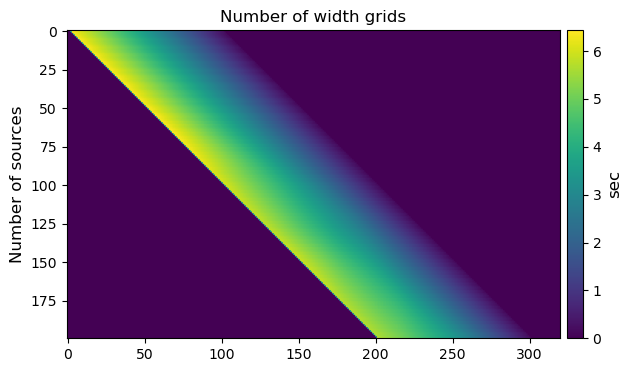

In [14]:
plt.figure(figsize=[10,4])
plt.imshow(ttime_obs[0].T)
plt.title("Number of width grids",fontsize=12)
plt.ylabel("Number of sources",fontsize=12)
plt.colorbar(pad=0.01).set_label(label="sec", size=12)

In [15]:
ttime_obs = torch.from_numpy(ttime_obs)

In [16]:
ttime_obs.shape

torch.Size([1, 1, 320, 200])

In [17]:
#vel = np.fromfile("./marm_intp.bin",dtype=np.float32)
vel = np.fromfile("./marm_intp_water.bin",dtype=np.float32)
vel.shape=(1,1,nx,ny)

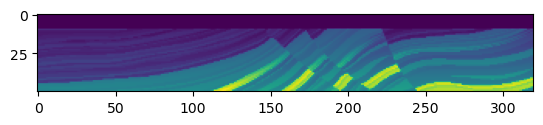

In [18]:
plt.imshow(vel[0].T)

In [19]:
vel = torch.from_numpy(vel)

In [20]:
vel.shape

torch.Size([1, 1, 320, 50])

In [21]:
PATH = "./weights/Tomography_CNN.pt"

In [22]:
model = torch.nn.DataParallel(Tomography_CNN().cuda(), device_ids=[0, 1, 2, 3])
#model = Tomography_CNN().cuda()

model.load_state_dict(torch.load(PATH))
#model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

ssim = SSIM()

In [23]:
def perc_clip_val(data,perc=100):
    # return clipping value by percent clip, does not apply clipping
    # data: array to clip
    # perc: percent value
    # output: min/max clip values
    mperc=(100.-perc)*0.01*0.5
    tmp=np.sort(data.flatten())
    minloc=int(len(tmp)*mperc)
    maxloc=len(tmp)-minloc-1
    clipmin=tmp[minloc]
    clipmax=tmp[maxloc]
    return clipmin,clipmax

In [24]:
def make_plot(y ,prediction, perc=97):
    #clipmin,clipmax = perc_clip_val(x, perc)
    plt.figure(figsize=[16,3])
    # input seismogram - one shotgather
    #plt.subplot(1,3,1)
    #plt.imshow(np.clip(x,clipmin,clipmax), aspect='auto',cmap='gray_r')
    # true velocity model
    plt.subplot(1,2,1)
    plt.imshow(y.T, vmin=1.5, vmax=5.0)
    plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
    plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
    plt.xlabel("Distance (km)",fontsize=10)
    plt.ylabel("Depth (km)",fontsize=8)
    plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
    # predicted velocity model
    plt.subplot(1,2,2)
    plt.imshow(prediction.T, vmin=1.5, vmax=5.0)
    plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
    plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
    plt.xlabel("Distance (km)",fontsize=10)
    plt.ylabel("Depth (km)",fontsize=8)
    plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [25]:
def plot_prediction(model, ibatch=0):
    since = time.time()
    model.eval()

    with torch.no_grad():
        image, label = ttime_obs.cuda(), vel.cuda()
        output = model(image)
        make_plot(label[ibatch].detach().cpu().numpy(), output[ibatch].detach().cpu().numpy())
        #np.save("./pred_marm.npy", output.detach().cpu().numpy())
        output.detach().cpu().numpy().astype(np.float32).tofile("pred_marm.bin")
    
    time_elapsed = time.time() - since
    print('Total time elapesd of test data {:.4f}ms'.format(time_elapsed))
    return output

In [26]:
def evaluate(model):
    model.eval()
    
    alpha = 2*np.pi/(20*h)*vmean
    omega = 2.*np.pi*freq - alpha * 1.0j
    
    test_mae = 0.0
    test_mse = 0.0
    test_ssim = 0.0
    test_loss = 0.0
    tr_loss = 0.0

    with torch.no_grad():
        image, label = ttime_obs.cuda(), vel.cuda()
        output = model(image)
        # model loss
        mae_loss = F.l1_loss(output, label)
        mse_loss = F.mse_loss(output, label)
        ssim_loss = ssim(output, label)
        loss = mae_loss + mse_loss + (1 - ssim_loss)
            
        test_mae += mae_loss.detach()
        test_mse += mse_loss.detach()
        test_ssim += ssim_loss.detach()
        test_loss += loss.detach()
        
        #traveltime loss
        image, label = ttime_obs.cuda(), ttime_obs.cuda()
        output = output.reshape(nx,ny)
        
        tomo = Tomo2d(nx,ny,h,device='cuda')
        tomo.factorize(omega, output)
        ttime = tomo.forward(output, torch.from_numpy(sxs).cuda(), sy, ry) * rcv_mask
        masked_t = ttime.transpose(0,1)
        masked_t = masked_t.reshape(1,1,nx,nshot)
        
        #loss = torch.sum(abs(masked_t - image))/(nshot*100)
        loss = F.l1_loss(masked_t, label) * 3.2
        tr_loss += loss.detach()
        
        tomo.finalize()
    
    print('Tr MAE: {:.6f} Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
        tr_loss, test_loss, test_mae, test_mse, test_ssim))
    return tr_loss, test_loss, test_mae, test_mse, test_ssim

Total time elapesd of test data 1.7891ms


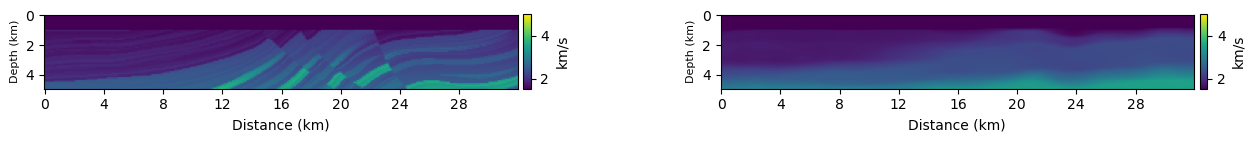

In [27]:
pred_init = plot_prediction(model, ibatch=0)

In [28]:
tr_loss, test_loss, test_mae, test_mse, test_ssim = evaluate(model)

Tr MAE: 0.015778 Loss: 0.7343 MAE: 0.1611 MSE 0.0689 SSIM 0.4957
